# Basic AI chatbot using langGraph (GRAPH API)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list" and the "add_messages" is function
    # in Annotated define how this message should be updated
    # in this case it append the message to the list, instead of updating the message
    messages: Annotated[list, add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

# llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm = init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct") # This is an alternative way to initialize the
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b3b7b90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b4cda30>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
# Node functionality
def chatBot(state: State):
    # Append the AI response to the messages list
    # return {"messages": state["messages"] + [llm.invoke(state["messages"])]}
    return {"messages": [llm.invoke(state["messages"])]}

In [6]:
graph_builder = StateGraph(State)

# Create the chatbot node
graph_builder.add_node("llm-chatbot", chatBot)

## Adding Edges
graph_builder.add_edge(START, "llm-chatbot")
graph_builder.add_edge("llm-chatbot", END)

# Compile Graph
graph = graph_builder.compile()

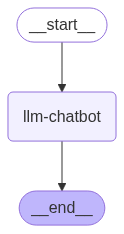

In [7]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # Handle the case where the graph cannot be displayed
    print(f"Error displaying graph: {e}")

In [8]:
response = graph.invoke({"messages": "HI"})

In [9]:
response['messages'][-1].content

'Hi! How are you today? Is there something I can help you with or would you like to chat?'

In [10]:
for event in graph.stream({"messages": "Hello! How are you?"}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm doing well, thank you for asking! I'm a large language model, so I don't have feelings or emotions like humans do, but I'm always happy to chat with you and help with any questions or topics you'd like to discuss. How about you? How's your day going so far?


## Chatbot with the tool

In [11]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)

tool.invoke("What is the capital of France?")

{'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}

In [12]:
# Create a Custom Function
# def multiply(a: int, b: int) -> int:
#     """Multiply a and b.

#     Args:
#         a (int): First int
#         b (int): Second int

#     Returns:
#         int: output integer.
#     """
#     return a * b


def multiply(a, b):
    """
    Multiply a and b.
    Args:
        a: The first number (int or str)
        b: The second number (int or str)
    Returns:
        int: output integer.
    """
    return int(a) * int(b)

In [13]:
tools= [tool,multiply]

In [14]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b3b7b90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b4cda30>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'descripti

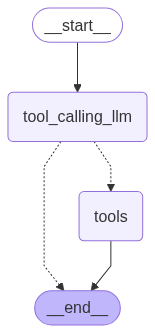

In [15]:
# StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


# Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Graph Builder
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
# If the latest message result from the assistant is a tool call, then tool_condition route to tool node
# If the latest message result from the assistant is a not tool call, then tool_condition route to END
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
response = graph.invoke({"messages": "What is the Recent AI news?"})

In [17]:
response['messages'][-1].content

"{'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}"

In [18]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the Recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fwcjevtrz)
 Call ID: fwcjevtrz
  Args:
    query: Recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}


In [19]:
# Multiple multiplication is working
response = graph.invoke({"messages": "what is the 5 multiplied by 3 and then multiplied by 4?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the 5 multiplied by 3 and then multiplied by 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (tm3a2aps1)
 Call ID: tm3a2aps1
  Args:
    a: 15
    b: 4
================================= Tool Message =================================
Name: multiply

60


In [20]:
# Research and the multiplying is not working
response = graph.invoke({"messages": "what is the AI new and 3 multiplied by 4?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the AI new and 3 multiplied by 4?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (w5pss2y4b)
 Call ID: w5pss2y4b
  Args:
    query: AI news
  multiply (7yq4rfhc0)
 Call ID: 7yq4rfhc0
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}
================================= Tool Message =================================
Name: multiply

12


ReAct Agent Architecture

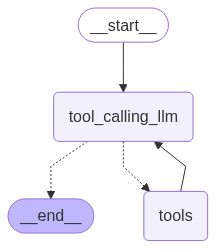

In [21]:
# StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


# Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Graph Builder
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
# If the latest message result from the assistant is a tool call, then tool_condition route to tool node
# If the latest message result from the assistant is a not tool call, then tool_condition route to END
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")

# Compile the graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# Research and the multiplying is working
response = graph.invoke({"messages": "Give me recent AI new and then multiply 3 by 4"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me recent AI new and then multiply 3 by 4
================================== Ai Message ==================================
Tool Calls:
  tavily_search (vfs8d0fwr)
 Call ID: vfs8d0fwr
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
  multiply (01rqr9h62)
 Call ID: 01rqr9h62
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

Recent AI news: 

The Tavily AI search tool was unable to provide results as it requires an API key.

The result of multiplying 3 by 4 is 12.


## Add Memory in Agentic Graph

In [23]:
response = graph.invoke({"messages": "Hello! my name is AK"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello! my name is AK
================================== Ai Message ==================================

Hello AK! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [24]:
response = graph.invoke({"messages": "What is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't have access to personal information about you, including your name. Is there something else I can assist you with?


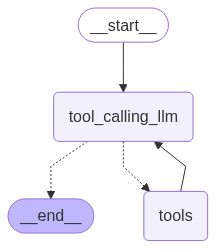

In [25]:
# StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


# Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Graph Builder
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
# If the latest message result from the assistant is a tool call, then tool_condition route to tool node
# If the latest message result from the assistant is a not tool call, then tool_condition route to END
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")

# Compile the graph
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": "1"}}
response = graph.invoke({"messages": "Hello! My name is Ak"}, config=config)
print(response)

{'messages': [HumanMessage(content='Hello! My name is Ak', additional_kwargs={}, response_metadata={}, id='47e67dba-95ce-4273-8470-cec368541635'), AIMessage(content="Hello Ak! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 2135, 'total_tokens': 2160, 'completion_time': 0.057214727, 'prompt_time': 0.059753764, 'queue_time': 0.19432974800000002, 'total_time': 0.116968491}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f13a6318-8947-47e2-986f-ba9b58261133-0', usage_metadata={'input_tokens': 2135, 'output_tokens': 25, 'total_tokens': 2160})]}


In [27]:
response['messages'][-1].content   

"Hello Ak! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [28]:
response = graph.invoke({"messages": "What is My name?"}, config=config)
response['messages'][-1].content

'Your name is Ak.'

In [29]:
response = graph.invoke({"messages": "Hay do you remember me?"}, config=config)
response['messages'][-1].content

'Yes, I remember you. You mentioned earlier that your name is Ak.'

## Streaming

In [30]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [31]:
def superBot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

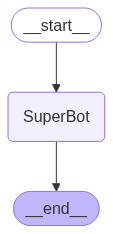

In [32]:
graph_builder = StateGraph(State)

# Node
graph_builder.add_node("SuperBot", superBot)

# Add Edges
graph_builder.add_edge(START, "SuperBot")
graph_builder.add_edge("SuperBot", END)

graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": "Hi, my name is Ak and I like watching movies"}, config=config)

{'messages': [HumanMessage(content='Hi, my name is Ak and I like watching movies', additional_kwargs={}, response_metadata={}, id='d568076d-5283-42f1-a503-7af3af8a0791'),
  AIMessage(content="Hi Ak! Nice to meet you! Movies are a great way to relax and escape into different worlds. What kind of movies do you enjoy watching? Are you into action, comedy, romance, or something else? Do you have a favorite director or actor? Let's chat about movies!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 21, 'total_tokens': 79, 'completion_time': 0.134674649, 'prompt_time': 0.002772335, 'queue_time': 0.193634346, 'total_time': 0.137446984}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--221b0880-56aa-4335-968f-923dae333e87-0', usage_metadata={'input_tokens': 21, 'output_tokens': 58, 'total_tokens': 79})]}

In the Streaming:

Methods: .stream() and astream()

    - This methods are sync and async methods for streaming back result

Additional parameters in the method for graph state

    - values: This stream the full state of the graph after each node is called

    - updates: This stream Updates to the graph after each node is called

In [34]:
config = {"configurable": {"thread_id": "2"}}
for chunk in graph.stream(
    {"messages": "Hi, my name is Ak and I like watching movies"},
    config=config,
    stream_mode="Updates",
):
    print(chunk)

In [35]:
for chunk in graph.stream(
    {"messages": "Hi, my name is Ak and I like watching movies"},
    config=config,
    stream_mode="values",
):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Ak and I like watching movies', additional_kwargs={}, response_metadata={}, id='2c8beba7-5bfe-444d-8e9d-78549b7cea90'), AIMessage(content="Nice to meet you, Ak! What's your favorite movie genre? Are you into action, comedy, romance, or something else? Do you have a go-to streaming platform or do you prefer watching movies in theaters? Let's chat about movies!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 21, 'total_tokens': 70, 'completion_time': 0.111886638, 'prompt_time': 0.002795324, 'queue_time': 0.19383565800000002, 'total_time': 0.114681962}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--02b1a54e-9b35-4201-93cb-ab664b81d0d7-0', usage_metadata={'input_tokens': 21, 'output_tokens': 49, 'total_tokens': 70}), HumanMessage(content='Hi, my name is Ak

In [36]:
config = {"configurable": {"thread_id": "3"}}
for chunk in graph.stream(
    {"messages": "Hi, my name is Ak and I like watching movies"},
    config=config,
    stream_mode="updates",
):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Ak! Nice to meet you! Movies can be a great way to relax and escape into different worlds. What kind of movies do you enjoy watching? Are you into action, comedy, drama, or something else? Do you have a favorite director or actor? I'm here to chat about movies with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 21, 'total_tokens': 84, 'completion_time': 0.148729905, 'prompt_time': 0.002776965, 'queue_time': 0.19413094, 'total_time': 0.15150687}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--172c18a9-3790-46f0-a0ae-88ed6038f7ac-0', usage_metadata={'input_tokens': 21, 'output_tokens': 63, 'total_tokens': 84})]}}


In [37]:
for chunk in graph.stream(
    {"messages": "I also like Cricket"},
    config=config,
    stream_mode="values",
):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Ak and I like watching movies', additional_kwargs={}, response_metadata={}, id='06c880b5-ae7b-4b8e-999b-7776ff0133ce'), AIMessage(content="Hi Ak! Nice to meet you! Movies can be a great way to relax and escape into different worlds. What kind of movies do you enjoy watching? Are you into action, comedy, drama, or something else? Do you have a favorite director or actor? I'm here to chat about movies with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 21, 'total_tokens': 84, 'completion_time': 0.148729905, 'prompt_time': 0.002776965, 'queue_time': 0.19413094, 'total_time': 0.15150687}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--172c18a9-3790-46f0-a0ae-88ed6038f7ac-0', usage_metadata={'input_tokens': 21, 'output_tokens': 63, 'total_tokens': 84})

In [38]:
# Async Method
config = {"configurable": {"thread_id": "4"}}
async for chunk in graph.astream_events(
    {"messages": ["Hi, my name is Ak and I like watching movies"]},
    config=config,
    version="v2",
):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, my name is Ak and I like watching movies']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'a50f3dae-88c6-4698-8ecf-1817c505de6d', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, my name is Ak and I like watching movies', additional_kwargs={}, response_metadata={}, id='97b34a8e-5378-4ba7-8841-50a95607f8e7')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'dae51764-dce0-4113-80a7-6a861bcf5c39', 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:6a670ffd-e71b-cd97-a4df-f288427f7796'}, 'parent_ids': ['a50f3dae-88c6-4698-8ecf-1817c505de6d']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, my name is Ak and I like watching mov